## INTERPOLATION ISSUES
## PURE IRON SLVTv0.2G1

Sarah T. Stewart <br>
sts@ucdavis.edu <br>
November 13, 2019<p>
    
<b>Acknowledgments</b><br>
The rational function interpolation routine was coded in python by Andrew Pepper based on Kerley, G. I. (1977). Rational function method of interpolation (No. LA-6903-MS). Los Alamos National Laboratory, Los Alamos, NM (United States).<p>
    
<b>THE INTERPOLATION ERROR PARAMETER (IEP)</b><br>
The IEP measures the quality of the interpolation scheme for a specific variable on a specific density-temperature grid. Robust interpolation of wide-ranging EOS tables is known to be a difficult problem. Most interpolation schemes individually interpolate each variable, which leads to interpolated states that are not thermodynamically self-consistent. While some thermodynamically consistent interpolation schemes have been developed (e.g., Zeman et al. 2019), they more computationally intensive than simpler interpolation methods and have not been widely implemented yet.

The IEP is calculated on the density-temperature grid using the following method: 
<ul>
    <li>Start with a grid that is twice as dense as the desired final grid and generate an ANEOS density-temperature table.
    <li>Split the table into two tables made from the even rows and columns and the odd rows and columns.
    <li>Interpolate for the odd index grid values using the even index table.
    <li>The IEP is given by (interpolated value-original value)/(original value) of the odd index table.
</ul>

A tabulated EOS must be sufficiently densely gridded to capture the phase boundaries. Otherwise, non-physical material response can arise during problems that cross the phase boundary. Simple interpolations schemes generally produce large errors in and near phase boundaries. See illustrative plots below. 

<b>We recommend that the interpolation scheme, the implementation of the scheme into EOS code functions (e.g., the source code), and IEP values should be reported in published works that use tabular EOS.</b>



In [1]:
# import libraries
%run eostable.py 
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]

# Record the verions information for these calculation for posterity
import platform
print('python version: ',platform.python_version())
del platform
import matplotlib
print('matplotlib version: ', matplotlib.__version__)
del matplotlib
import numpy
print('numpy version: ', numpy.__version__)
del numpy
import scipy
print('scipy version: ', scipy.__version__)
del scipy
import pandas
print('pandas version: ', pandas.__version__)
del pandas

# this prevents some error messages for inline plotting in a jupyter notebook
%matplotlib inline 
# import python libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from copy import deepcopy
import numpy as np
from scipy import interpolate
import colormaps as local_cmaps
import subprocess
import pandas as pd
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
#
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["patch.force_edgecolor"] = True

python version:  3.7.4
matplotlib version:  3.1.1
numpy version:  1.17.2
scipy version:  1.3.1
pandas version:  0.25.1


In [2]:
# set code flags to use code copied from primary jupyter notebook
DEVMODE=1
MAKEGADGETTABLE=0
REMOVETENSIONFLAG=1  # 0- keep tension region; 1- remove tension region

# first set up the ORIGINAL grid used in the calculations
# CUT AND PASTE THE ORIGINAL GRID HERE

gridflag=1
if gridflag == 1: # new form for the high resolution table entries in 301 table. Try for 1e6 values
    # define the temperature array for the SESAME table
    # 0 K is changed to 1 K
    # T0REF is inserted into the table if it is not present in the original array
    # need to have extra temperature resolution around the triple point
    gridtvals  = [0, 100, 1750, 1950, 20000.,1.E5, 1.E7] # K -- this array defines the edges of the segments along the grid, 0 is changed to 1 below
    gridtstyle = [1,1,1,1,1,0] # 1 for linear, 0 for log in each segment
    gridtnpts  = [2, 75., 100, 500.,85.,50.] # number of grid points in each segment
    # define the density array for the SESAME AND GADGET2 tables
    # R0REF is inserted into the table if it is not present in the original array
    # need to have extra density resolution around the triple point
    # 0 g/cm3 is removed if present
    gridrvals  = [1.e-20, 0.5, 6.6, 7.4, 20., 30.] # g/cm3 -- this array defines the edges of the segments along the grid
    gridrstyle = [0, 1, 1, 1, 1] # 1 for linear, 0 for log in each segment
    gridrnpts  = [150, 84, 101, 400, 100] # number of grid points in each segment
    # define the specific entropy array for the GADGET2 table
    # 0 MJ/K/kg is removed if present
    gridsvals  = [1.e-4,.1] # MJ/K/kg -- this array defines the edges of the segments along the grid
    gridsstyle = [0] # 1 for linear, 0 for log in each segment
    gridsnpts  = [800] # number of grid points in each segment
#
# ====>>>>>> YOU NEED TO MAKE SURE THESE VALUES MATCH ANEOS.INPUT  <<<<=====
MODELNAME = 'Iron-ANEOS-SLVTv0.2G1'
# Header information must all be compatible with float format
MATID = 1.0        # MATID number
DATE = 191105.     # Date as a single 6-digit number YYMMDD
VERSION = 0.2      # ANEOS Parameters Version number
FMN = 26.          # Formula weight in atomic numbers for Fe
FMW = 55.847       # Formula molecular weight (g/cm3) for Fe
# The following define the default initial state for material in the 201 table
R0REF   = 8.06     # g/cm3 *** R0REF is inserted into the density array; using gamma-iron for rho0
K0REF   = 1.51E12  # dynes/cm2; using gamma-iron for rho0
T0REF   = 298.     # K -- *** T0REF is inserted into the temperature array
P0REF   = 1.E6     # dynes/cm2 -- this defines the principal Hugoniot calculated below


In [3]:
# THIS CELL HAS CODE TO GENERATE THE GRIDS AND WRITES TO A FILE TO BE READ BY ANEOS
print('GENERATING ARRAYS FOR THE INDICES OF THE TABULATED EOS.')
#-------------- the following code generates the temperature array
gridtarr = []
for iir in  range(1,len(gridtvals)):
    if gridtstyle[iir-1] == 1:
        # linear region
        temptarr = np.arange(gridtnpts[iir-1])/gridtnpts[iir-1]*(gridtvals[iir]-gridtvals[iir-1])+gridtvals[iir-1]
    if gridtstyle[iir-1] == 0:
        # log region
        logstep = (np.log10(gridtvals[iir])-np.log10(gridtvals[iir-1]))/gridtnpts[iir-1]
        temptarr = np.power(10.,np.log10(gridtvals[iir-1])+(np.arange(gridtnpts[iir-1]))*logstep)
    gridtarr = np.concatenate((gridtarr,temptarr))
# check if T0REF already in the grid
#indexT0REF = get_indexes(T0REF,gridtarr)
indexT0REF = np.where(abs(T0REF-gridtarr)<1.E-4)[0]
if len(indexT0REF) == 0:
    # insert T0REF K into the array
    indexT0REF = np.where((gridtarr-T0REF)>0.)[0]
    gridtarr = np.concatenate((gridtarr[0:indexT0REF[0]],[T0REF],gridtarr[indexT0REF[0]::]))
    if indexT0REF[0]>1:
        print('Inserted the REFERENCE TEMPERATURE INTO THE ARRAY:',gridtarr[indexT0REF[0]-2:indexT0REF[0]+3])
    else:
        print('Inserted the REFERENCE TEMPERATURE INTO THE ARRAY:',gridtarr[indexT0REF[0]-1:indexT0REF[0]+3])
else:
    print('T0REF already in temperature array: ',T0REF,gridtarr[indexT0REF[0]-2:indexT0REF[0]+2])
# Remove 0 K or convert to 1 K
indexzero = get_indexes(0.,gridtarr)
indexone = get_indexes(1.,gridtarr)
if len(indexzero) == 1 and len(indexone) == 0:
    gridtarr[indexzero] = 1.
    print('Zero kelvin changed to 1 kelvin.')
else:
    gridtarr = np.delete(gridtarr, indexzero)
    print('Deleted zero K index.')
#
#gridtsize = len(grdtarr)
print('Number of temperature points: ',len(gridtarr))
#print(gridtarr)
#------------ the following code generates the density array
gridrarr = []
for iir in range(1,len(gridrvals)):
    if gridrstyle[iir-1] == 1:
        # linear region
        temprarr = np.arange(gridrnpts[iir-1])/gridrnpts[iir-1]*(gridrvals[iir]-gridrvals[iir-1])+gridrvals[iir-1]
    if gridrstyle[iir-1] == 0:
        # log region
        logstep = (np.log10(gridrvals[iir])-np.log10(gridrvals[iir-1]))/gridrnpts[iir-1]
        temprarr = np.power(10.,np.log10(gridrvals[iir-1])+(np.arange(gridrnpts[iir-1]))*logstep)
    gridrarr = np.concatenate((gridrarr,temprarr))
# check if R0REF already in the grid
#indexR0REF = get_indexes(R0REF,gridrarr)
indexR0REF = np.where(abs(R0REF-gridrarr)<1.E-4)[0]
if len(indexR0REF) == 0:
    # insert R0REF  into the array
    indexR0REF = np.where((gridrarr-R0REF)>0.)[0]
    gridrarr = np.concatenate((gridrarr[0:indexR0REF[0]],[R0REF],gridrarr[indexR0REF[0]::]))
    print('Inserted the REFERENCE DENSITY INTO THE ARRAY:',gridrarr[indexR0REF[0]-2:indexR0REF[0]+3])
    #print('NOT INSERTING REFERENCE DENSITY INTO THE ARRAY.')
else:
    print('R0REF already in density array: ',R0REF,gridrarr[indexR0REF[0]-2:indexR0REF[0]+2])
# Remove 0 g/cm3 if present
indexzero = get_indexes(0.,gridrarr)
if len(indexzero) == 1:
    gridrarr = np.delete(gridrarr, indexzero)
    print('Deleted zero g/cm3 index.')
#
#gridrsize = len(gridrarr)
print('Number of density points: ',len(gridrarr))
#print(gridrarr)
#------------ the following code generates the specific entropy array for gadget tables
gridsarr = []
for iir in range(1,len(gridsvals)):
    if gridsstyle[iir-1] == 1:
        # linear region
        tempsarr = np.arange(gridsnpts[iir-1])/gridsnpts[iir-1]*(gridsvals[iir]-gridsvals[iir-1])+gridsvals[iir-1]
    if gridsstyle[iir-1] == 0:
        # log region
        logstep = (np.log10(gridsvals[iir])-np.log10(gridsvals[iir-1]))/gridsnpts[iir-1]
        tempsarr = np.power(10.,np.log10(gridsvals[iir-1])+(np.arange(gridsnpts[iir-1]))*logstep)
    gridsarr = np.concatenate((gridsarr,tempsarr))
# Remove 0 MJ/K/kg if present
indexzero = get_indexes(0.,gridsarr)
if len(indexzero) == 1:
    gridsarr[indexzero]=1.e-20
#    gridsarr = np.delete(gridsarr, indexzero)
    print('replaced zero MJ/K/kg index with 1.E-20')
#gridssize = len(gridsarr)
#
print('Number of specific entropy points: ',len(gridsarr))
#print(gridsarr)

print('Number of words in the standard SESAME 301 table (NR, NT, R, T, P, IE, HFE)=',2.+len(gridrarr)+len(gridtarr)+len(gridrarr)*len(gridtarr)*3.)
#-----------------------------------------------------------
#
if DEVMODE:
    print('WRITING tablegrid.txt FOR ANEOS in the local directory.\n')
    # write the table arrays to a file for the ANEOS driver to read in
    tablegridfile = open("tablegrid.txt","w")  
    tablegridfile.write("{:.6e}".format(MATID)+'\n')  
    tablegridfile.write("{:.6e}".format(DATE)+'\n')  
    tablegridfile.write("{:.6e}".format(VERSION)+'\n')  
    tablegridfile.write("{:.6e}".format(FMN)+'\n')  
    tablegridfile.write("{:.6e}".format(FMW)+'\n')  
    tablegridfile.write("{:.6e}".format(R0REF)+'\n')  
    tablegridfile.write("{:.6e}".format(K0REF)+'\n')  
    tablegridfile.write("{:.6e}".format(T0REF)+'\n')  
    tablegridfile.write("{:.6e}".format(len(gridrarr))+'\n')  # number of density points
    tablegridfile.write("{:.6e}".format(len(gridtarr))+'\n')  # number of temperature points
    for i in range(0,len(gridrarr)):
        tablegridfile.write("{:.6e}".format(gridrarr[i])+'\n')
    for i in range(0,len(gridtarr)):
        tablegridfile.write("{:.6e}".format(gridtarr[i])+'\n')
    tablegridfile.close()
#
#-----------------------------------------------------
# Output GADGET2 Table information
if MAKEGADGETTABLE:
    print('Number of words in the extended GADGET2 EOS table (NR, NS, R, S, P, T, IE, CS, HFE, CV, KPA, MDQ)=',2.+len(gridrarr)+len(gridtarr)+len(gridrarr)*len(gridtarr)*8.)
#------------------------------------------------------

#----------------------------------------------------
# Sp. Internal Energy grid for Tillotson
tillearr = np.power(10.,np.arange(800)/800.*6.-3.) # MJ/kg
tillearr = np.append(0.,tillearr)
print('Number of specific internal energy points for Tillotson EOS: ',len(tillearr))
#----------------------------------------------------
# Paranoia check
# make sure all table grid values are unique
if (len(np.unique(gridtarr))!=len(gridtarr)):
    print('NON-UNIQUE VALUES IN TEMP ARRAY')
    stopthecode
if (len(np.unique(gridrarr))!=len(gridrarr)):
    print('NON-UNIQUE VALUES IN DENSITY ARRAY')
    stopthecode
if (len(np.unique(gridsarr))!=len(gridsarr)):
    print('NON-UNIQUE VALUES IN SP. ENTROPY ARRAY')
    stopthecode
if (len(np.unique(tillearr))!=len(tillearr)):
    print('NON-UNIQUE VALUES IN SP. ENERGY ARRAY')
    stopthecode

#----------------------------------------------------

print('\nDone generating EOS grids.\n')
print('\nCHECK THAT THE GRID ARRAYS ARE EVEN IN LENGTH.\n')

# END TABLE GRIDDING INFORMATION

GENERATING ARRAYS FOR THE INDICES OF THE TABULATED EOS.
T0REF already in temperature array:  298.0 [254. 276. 298. 320.]
Zero kelvin changed to 1 kelvin.
Number of temperature points:  812
Inserted the REFERENCE DENSITY INTO THE ARRAY: [7.9985 8.03   8.06   8.0615 8.093 ]
Number of density points:  836
Number of specific entropy points:  800
Number of words in the standard SESAME 301 table (NR, NT, R, T, P, IE, HFE)= 2038146.0
WRITING tablegrid.txt FOR ANEOS in the local directory.

Number of specific internal energy points for Tillotson EOS:  801

Done generating EOS grids.


CHECK THAT THE GRID ARRAYS ARE EVEN IN LENGTH.



In [4]:
if DEVMODE:
    # call aneos in the local directory
    # output file is in the local directory
    print('RUNNING IN DEVELOPMENT MODE')
    print('Calling aneos in the local directory.')
    completed = subprocess.run(['./aneos'])
    print('Aneos call complete. CHECK THAT A NEW ANEOS.OUTPUT FILE WAS CREATED.')
    print('aneos call result: ', completed.returncode)
    print('Check ANEOS.OUTPUT file for errors.')
else:
    print('RUNNING IN RELEASE MODE: NO ANEOS SYSTEM CALL.')
    print('READING IN EOS DISTRIBUTION FILES.')

RUNNING IN DEVELOPMENT MODE
Calling aneos in the local directory.
Aneos call complete. CHECK THAT A NEW ANEOS.OUTPUT FILE WAS CREATED.
aneos call result:  0
Check ANEOS.OUTPUT file for errors.


In [5]:
# READ IN NEW ANEOS MODEL and fill the extEOStable class object
# source in eostable.py
#------------------------------------------------------------------
NewEOS  = extEOStable() # FIRST make new empty EOS object
NewEOS.loadextsesame('NEW-SESAME-EXT.TXT') # LOAD THE EXTENDED 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
NewEOS.loadstdsesame('NEW-SESAME-STD.TXT') # LOAD THE STANDARD 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
NewEOS.MODELNAME = MODELNAME # string set above in user input
NewEOS.MDQ = np.zeros((NewEOS.NT,NewEOS.ND)) # makes the empty MDQ array
#print(NewEOS.units) # these are the default units for SESAME rho-T tables
#'Units: g/cm3, K, GPa, MJ/kg, MJ/kg, MJ/K/kg, cm/s, MJ/K/kg, KPA flag. 2D arrays are (NT,ND).'

# Add the header info to the table. This could be done during the loading. 
# if made from this notebook, these values are set in the user-input above.
# ** MAKE SURE THEY MATCH ANEOS.INPUT **
NewEOS.MATID   = MATID
NewEOS.DATE    = DATE
NewEOS.VERSION = VERSION
NewEOS.FMN     = FMN
NewEOS.FMW     = FMW
NewEOS.R0REF   = R0REF
NewEOS.K0REF   = K0REF
NewEOS.T0REF   = T0REF
NewEOS.P0REF   = P0REF
#
# Load the information from ANEOS.INPUT and ANEOS.OUTPUT
NewEOS.loadaneos(aneosinfname='ANEOS.INPUT',aneosoutfname='ANEOS.OUTPUT')
#
# calculate the principal Hugoniot from the table
if DEVMODE:
    # calculate the Hugoniot and write to a file
    NewEOS.calchugoniot(r0=NewEOS.R0REF,t0=NewEOS.T0REF,writefilename='NEW-SESAME-HUG.TXT')
else:
    # just calculate the Hugoniot and put it in the EOS object
    NewEOS.calchugoniot(r0=NewEOS.R0REF,t0=NewEOS.T0REF)
#
# calculate the 1-bar profile; loop over temp
NewEOS.onebar.T = np.zeros(NewEOS.NT)
NewEOS.onebar.S = np.zeros(NewEOS.NT)
NewEOS.onebar.rho = np.zeros(NewEOS.NT)
it0 = np.where(NewEOS.T >= NewEOS.T0REF)[0]
id0 = np.arange(NewEOS.ND)#np.where(NewEOS.rho >= 0.8*NewEOS.R0REF)[0]
for iit in range(0,NewEOS.NT):
    NewEOS.onebar.T[iit] = NewEOS.T[iit]
    NewEOS.onebar.S[iit] = np.interp(1.E-4,NewEOS.P[iit,id0],NewEOS.S[iit,id0])
    NewEOS.onebar.rho[iit] = np.interp(1.E-4,NewEOS.P[iit,id0],NewEOS.rho[id0])
    #print(iit,NewEOS.onebar.rho[iit],NewEOS.onebar.T[iit],NewEOS.onebar.S[iit]*1.E3)


Done loading ANEOS files.
ANEOS WAS CALLED WITH THE FOLLOWING INPUT, LOADED FROM FILE  ANEOS.INPUT
 *ANEOS INPUT FILE FOR STSM JUPYTER NOTEBOOK. VARIABLES MUST BE SPACED BY 10 CHARACTERS.
 *         EOS#      string for EOS name           .....Hugoniot initial........ long
 *                                                 T(eV)           Rho(g/cc)     flag
 ANEOS1    -1        'IRON-ANEOS-SLVTv0.2'         THUG=0.02568    RHUG=7.874    LONG

 *
 *         nelem     type      rho0      temp0(K)  press0    B0/-Cbulk Gamma0    Tdebye(K)
 *         V01       V02       V03       V04       V05       V06       V07       V08
 ANEOS2    1         4         8.06      298.      1.e6      1.51E12   1.90      -450.0 

 *         or S1     3*C24     erg/g     or -Em    C53       C54       H0        C41
 *         V09       V10       V11       V12       V13       V14       V15       V16
 * Esep adjusted to match 1-bar boiling pt with cv=1.35*3nR
 ANEOS3    0.        1.5       10.20E10  1809.     0. 

In [6]:
# Make a NOTENSION TABLE and GADGET TABLE
################### REMOVE TENSION REGION ###########################
## The GADGET2 tables do not have a tension region. 
## If the gadget2 table is selected, then must generate a no-tension table
if MAKEGADGETTABLE:
    REMOVETENSIONFLAG=1  # 0- keep tension region; 1- remove tension region

# minimum pressure 1.E-30
# minimum sp energy about 1.E-4 before negative entropy region
# minimum sp entropy about 1.E-5 before negative entropy region
# minimum HFE about 1.E-3 before negative entropy region
# minimum sound speed about 1.E-10 before negative entropy region
# minimum sp heat capacity about 1.E-4 before negative entropy region

## FUTURE WORK: THIS SECTION COULD USE THE LEVER RULE TO FILL IN THE MISSING POINTS
## SINCE MANY VALUES ARE NEAR THE LOWER LIMITS IN THE SUBLIMATION REGION ANYWAY, 
## HERE, TENSION REGION VALUES ARE FILLED IN WITH THE ADJACENT S-V DOME VALUES
## This is obviously bad for interpolations. Fix for future work.
if REMOVETENSIONFLAG:
    # First make a deep copy of the original table with the tension region
    NewEOSorig = deepcopy(NewEOS)
    NewEOS.MODELNAME = NewEOS.MODELNAME+'notension'
    # THIS SECTION REWRITES NEGATIVE PRESSURE REGION
    # The tension region is in the solid-vapor phase boundary. 
    # Use the liquid-vapor phase boundary. Below the temperature of the triple point, it is the sublimation curve.
    # But the pressures for the solid calculation is spurious at very low pressures, so use the vapor pressure.
    # HFE = GFE + TS
    print('REMOVING TENSION REGION FROM THE ORIGINAL ANEOS TABLE.')
    for itt in range(NewEOS.NT-1,-1,-1):
        tmp = np.where(NewEOS.P[itt,:] < 0.)
        if (len(tmp[0]) > 0):
            badind = tmp[0]
            if badind[0] > 0:
                #print(itt, len(badind), NewEOS.T[itt], 'tension only', NewEOS.P[itt,badind[0]-4:badind[0]+1])
                # at this temperature, all densities are the same pressure in the vapor dome
                # so use the adjacent positive pressure value
                # do the same for all the variables since there is very little change in this region of the dome.
                # Errors introduced by interpolating the vapor curve are comparable to
                # recalculating the lever rule. Would need to call ANEOS again to get good end point values
                # to calculate the mass-weighted value via the lever rule.
                NewEOS.P[itt,badind] = np.full(len(badind),NewEOS.P[itt,badind[0]-1])
                NewEOS.U[itt,badind] = np.full(len(badind),NewEOS.U[itt,badind[0]-1])
                NewEOS.S[itt,badind] = np.full(len(badind),NewEOS.S[itt,badind[0]-1])
                NewEOS.A[itt,badind] = np.full(len(badind),NewEOS.A[itt,badind[0]-1])
                NewEOS.cs[itt,badind] = np.full(len(badind),NewEOS.cs[itt,badind[0]-1])
                NewEOS.cv[itt,badind] = np.full(len(badind),NewEOS.cv[itt,badind[0]-1])
                NewEOS.KPA[itt,badind] = np.full(len(badind),2)
                NewEOS.MDQ[itt,badind] = np.full(len(badind),-1) # replaced tension region flag
            else:
                print('SOMETHING VERY WRONG WITH TENSION IN THE TABLE')
                makethecodestop # please tell me a more graceful way to stop the notebook
    #
    # THIS SECTION RESETS NEGATIVE SPECIFIC ENTROPIES WITH ADJACENT VALUES OR MINIMUM POSITIVE VALUES
    # THESE VALUES TYPICALLY DEFINE THE COLD COMPRESSION LIMIT OF THE MATERIAL
    # OR SPURIOUS NEGATIVE ENTROPIES AT VERY LOW PRESSURES (IMPERFECT DEBYE MODEL IN ANEOS)
    for itt in range(NewEOS.NT-1,-1,-1):
        tmp = np.where(NewEOS.S[itt,:] < 0.)
        if (len(tmp[0]) > 0):
            badind = tmp[0]
            if badind[0] > 0:
                #print(itt, antarr[itt], andarr[badind[0]], badind[0],len(badind),'negative entropy', ansarr[itt,badind[0]],ansarr[itt,badind[0]-1])
                NewEOS.P[itt,badind] = np.full(len(badind),NewEOS.P[itt,badind[0]-1]) # use the adjacent pressure at this temperature in the dome
                NewEOS.U[itt,badind] = np.full(len(badind),NewEOS.U[itt,badind[0]-1])
                NewEOS.S[itt,badind] = np.full(len(badind),NewEOS.S[itt,badind[0]-1])
                NewEOS.A[itt,badind] = np.full(len(badind),NewEOS.A[itt,badind[0]-1])
                NewEOS.cs[itt,badind] = np.full(len(badind),NewEOS.cs[itt,badind[0]-1])
                NewEOS.cv[itt,badind] = np.full(len(badind),NewEOS.cv[itt,badind[0]-1])
                #NewEOS.KPA[itt,badind]  # leave as original region flag
                NewEOS.MDQ[itt,badind] = np.full(len(badind),-2) # negative entropies flag
                #print('Some NEGATIVE  S AT THIS INDEX, TEMP(K): ',itt, NewEOS.T[itt],NewEOS.P[itt,badind[0]-1],NewEOS.P[itt,badind[0]-2]) #, badind[0],len(badind),'negative entropy', NewEOS.S[itt,badind[0]])
            if badind[0] == 0:
                print('All S VALUES NEGATIVE AT THIS INDEX, TEMP(K): ',itt, NewEOS.T[itt]) #, badind[0],len(badind),'negative entropy', NewEOS.S[itt,badind[0]])
                NewEOS.S[itt,badind] = np.full(len(badind),1.E-10)            
                NewEOS.U[itt,badind] = np.full(len(badind),1.E-10) # also replace the negative sp. internal energies           
                NewEOS.MDQ[itt,badind] = np.full(len(badind),-2) # negative entropies flag

    #### ONLY WRITE A NEW TABLE IN DEVELOPMENT MODE
    if DEVMODE:
        #### WRITE NEW SESAME TABLE WITH NO TENSION REGION
        #     WRITE STANDARD (SHORT) SESAME FILE
        #     WRITE SESAME TABLE TO FILE LIMITED TO P, E, HFE
        NewEOS.writestdsesame(writestdsesfname="NEW-SESAME-STD-NOTENSION.TXT")

#### ONLY WRITE A NEW TABLE IN DEVELOPMENT MODE
if DEVMODE:
    #### WRITE MDQ Flag as a 301-style table
    NewEOS.writemdqsesame(writemdqsesfname="NEW-SESAME-MDQ.TXT")
#
#--------------------------------------------------------------------------
########## MAKE GADGET2 EOS TABLE ARRAYS ###################
# LATER WE CAN TURN THIS INTO A FUNCTION IN THE GADGET EOS OBJECT
# FLAG IS SET ABOVE IN THE USER INPUT SECTION
# MAKEGADGETTABLE = 1 # 1 - do it ; 0 - skip it
if MAKEGADGETTABLE:
    print('Starting interpolation for GADGET table.')
    GadEOS  = extGADtable() # make new empty Gadget EOS object
    #
    # rho array is andarr to match the SESAME table
    # S array is gridsarr
    GadEOS.ND  = len(gridrarr)
    GadEOS.NS  = len(gridsarr)
    GadEOS.rho = gridrarr
    GadEOS.S   = gridsarr
    GadEOS.P   = np.zeros((GadEOS.NS,GadEOS.ND))
    GadEOS.T   = np.zeros((GadEOS.NS,GadEOS.ND))
    GadEOS.U   = np.zeros((GadEOS.NS,GadEOS.ND))
    GadEOS.A   = np.zeros((GadEOS.NS,GadEOS.ND))
    GadEOS.cs  = np.zeros((GadEOS.NS,GadEOS.ND))
    GadEOS.cv  = np.zeros((GadEOS.NS,GadEOS.ND))
    GadEOS.KPA = np.zeros((GadEOS.NS,GadEOS.ND))
    GadEOS.MDQ = np.zeros((GadEOS.NS,GadEOS.ND))
    GadEOS.MODELNAME = NewEOS.MODELNAME+'-gadget-linear-int'
    #
    # some combinations of density and sp. entropy are not in the EOS surface
    # in these cases, apply minimum values
    gadpmin  = np.min(NewEOS.P) # GPa
    gadsmin  = 1.E-30     # MJ/K/kg
    gademin  = np.min(NewEOS.U)    # MJ/kg
    gadtmin  = 1.     # K
    gadcmin  = np.min(NewEOS.cs) # cm/s
    gadcvmin = 0.     # MJ/K/kg
    gadamin  = np.min(NewEOS.A) # can be negative    # MJ/kg
    print('Minimum values used in the rational function interpolation scheme:')
    print('gadpmin,gadsmin,gademin,gadtmin,gadcmin,gadcvmin,gadamin=')
    print(gadpmin,gadsmin,gademin,gadtmin,gadcmin,gadcvmin,gadamin)
    #
    # some combinations of density and sp. entropy are not in the EOS surface
    # in these cases, fill the region with the adjacent real values from the original T-RHO table
    # ----------------------------------------------------------
    # SIMPLE LINEAR INTERPOLATION TO FLIP T-RHO to S-RHO table
    print("LINEAR INTERPOLATION FOR GADGET TABLE.")
    for iid in range(0,GadEOS.ND):
        # same density arrays for the T-rho table and S-rho table
        sall1d = NewEOS.S[:,iid]
        pall1d = NewEOS.P[:,iid]
        eall1d = NewEOS.U[:,iid]
        tall1d = NewEOS.T[:]
        call1d = NewEOS.cs[:,iid]
        cvall1d = NewEOS.cv[:,iid]
        aall1d = NewEOS.A[:,iid]
        kall1d = NewEOS.KPA[:,iid]
        mdqall1d = NewEOS.MDQ[:,iid]
        # interpolate P at the new S
        testinterp = interpolate.interp1d(sall1d,pall1d)
        tmpind = np.where(gridsarr < np.max(sall1d))[0]
        GadEOS.P[tmpind,iid] = testinterp(gridsarr[tmpind])
        tmpind = np.where(gridsarr >= np.max(sall1d))[0]
        GadEOS.P[tmpind,iid] = pall1d[NewEOS.NT-1]
        # interpolate E at the new S
        testinterp = interpolate.interp1d(sall1d,eall1d)
        tmpind = np.where(gridsarr < np.max(sall1d))[0]
        GadEOS.U[tmpind,iid] = testinterp(gridsarr[tmpind])
        tmpind = np.where(gridsarr >= np.max(sall1d))[0]
        GadEOS.U[tmpind,iid] = eall1d[NewEOS.NT-1]
        # interpolate T at the new S
        testinterp = interpolate.interp1d(sall1d,tall1d)
        tmpind = np.where(gridsarr < np.max(sall1d))[0]
        GadEOS.T[tmpind,iid] = testinterp(gridsarr[tmpind])
        tmpind = np.where(gridsarr >= np.max(sall1d))[0]
        GadEOS.T[tmpind,iid] = tall1d[NewEOS.NT-1]
        # interpolate sound speed at the new S
        testinterp = interpolate.interp1d(sall1d,call1d)
        tmpind = np.where(gridsarr < np.max(sall1d))[0]
        GadEOS.cs[tmpind,iid] = testinterp(gridsarr[tmpind])
        tmpind = np.where(gridsarr >= np.max(sall1d))[0]
        GadEOS.cs[tmpind,iid] = call1d[NewEOS.NT-1]
        # interpolate sp. heat capacity at the new S
        testinterp = interpolate.interp1d(sall1d,cvall1d)
        tmpind = np.where(gridsarr < np.max(sall1d))[0]
        GadEOS.cv[tmpind,iid] = testinterp(gridsarr[tmpind])
        tmpind = np.where(gridsarr >= np.max(sall1d))[0]
        GadEOS.cv[tmpind,iid] = call1d[NewEOS.NT-1]
        # interpolate HFE at the new S
        testinterp = interpolate.interp1d(sall1d,aall1d)
        tmpind = np.where(gridsarr < np.max(sall1d))[0]
        GadEOS.A[tmpind,iid] = testinterp(gridsarr[tmpind])
        tmpind = np.where(gridsarr >= np.max(sall1d))[0]
        GadEOS.A[tmpind,iid] = call1d[NewEOS.NT-1]
        # interpolate phase information KPA flag at the new S
        testinterp = interpolate.interp1d(sall1d,kall1d)
        tmpind = np.where(gridsarr < np.max(sall1d))[0]
        GadEOS.KPA[tmpind,iid] = testinterp(gridsarr[tmpind])
        tmpind = np.where(gridsarr >= np.max(sall1d))[0]
        GadEOS.KPA[tmpind,iid] = call1d[NewEOS.NT-1]
        # interpolate model development quality flag at the new S
        testinterp = interpolate.interp1d(sall1d,mdqall1d)
        tmpind = np.where(gridsarr < np.max(sall1d))[0]
        GadEOS.MDQ[tmpind,iid] = testinterp(gridsarr[tmpind])
        tmpind = np.where(gridsarr >= np.max(sall1d))[0]
        GadEOS.MDQ[tmpind,iid] = call1d[NewEOS.NT-1]
    #
    GadEOSlin = deepcopy(GadEOS)
    #
    '''
    # ----------------------------------------------------------
    # 1D RATIONAL FUNCTION INTERPOLATION METHOD FROM KERLEY
    print("RATIONAL FUNCTION INTERPOLATION TO GENERATE GADGET2 EOS TABLE.")
    for iid in range(0,GadEOS.ND):
        GadEOS.MODELNAME = NewEOS.MODELNAME+'-gadget-ratfunc-int'
        #
        # same density arrays for the T-rho table and S-rho table
        sall1d  = NewEOS.S[:,iid]
        pall1d  = NewEOS.P[:,iid]
        eall1d  = NewEOS.U[:,iid]
        tall1d  = NewEOS.T[:]
        call1d  = NewEOS.cs[:,iid]
        cvall1d = NewEOS.cv[:,iid]
        aall1d  = NewEOS.A[:,iid]
        #kall1d = NewEOS.KPA[:,iid]
        #mdqall1d = NewEOS.MDQ[:,iid]
        #
        # interpolate P at the new S
        GadEOS.P[:,iid] = rf1d(sall1d,pall1d,gridsarr,gadpmin)
        # interpolate E at the new S
        GadEOS.U[:,iid] = rf1d(sall1d,eall1d,gridsarr,gademin)
        # interpolate T at the new S
        GadEOS.T[:,iid] = rf1d(sall1d,tall1d,gridsarr,gadtmin)
        # interpolate sound speed at the new S
        GadEOS.cs[:,iid] = rf1d(sall1d,call1d,gridsarr,gadcmin)
        # interpolate sp. heat capacity at the new S
        GadEOS.cv[:,iid] = rf1d(sall1d,cvall1d,gridsarr,gadcvmin)
        # interpolate HFE at the new S
        GadEOS.A[:,iid] = rf1d(sall1d,aall1d,gridsarr,gadamin)
        # Do not interpolate KPA or MDQ with rational function interp. Use Linear.
        # do not overwrite the linear interpolation above.
    '''
    #
    print('Done interpolating the gadget2 table.')
    #print('Using RATIONAL FUNCTION INTERPOLATION EXCEPT FOR KPA and MDQ FLAGS (bilinear).')
    if DEVMODE:
        # ONLY WRITE GADGET2 TABLE TO DISK IN DEVELOPMENT MODE
        #### WRITE NEW GADGET2 TABLE WITH NO TENSION REGION
        #### This ascii table format follows the sesame table format of 5 columns of numbers in 16.8e format
        #### the STYLE variable is just a counter to 5 to know when to write a newline
        GadEOS.writestdgadget(writestdgadgetfname="NEW-GADGET-STD-NOTENSION.TXT")
        GadEOS.writeextgadget(writeextgadgetfname="NEW-GADGET-EXT-NOTENSION.TXT")


REMOVING TENSION REGION FROM THE ORIGINAL ANEOS TABLE.
All S VALUES NEGATIVE AT THIS INDEX, TEMP(K):  0 1.0
Done writing the STD SESAME 301 notension table to local directory:  NEW-SESAME-STD-NOTENSION.TXT
Done writing the MDQ Flag as a 301-style table to local directory:  NEW-SESAME-MDQ.TXT


In [7]:
###### TEST INTERPOLATION #####
## EVEN indices are the original array
## Interpolate on the ODD indices to reconstruct the EVEN values and compare
EvenEOS = extEOStable() 
OddEOS = extEOStable() 
IntEvenEOS = extEOStable() 

# Fill EVEN EOS
EvenEOS.rho = np.copy(NewEOS.rho[::2])
EvenEOS.T = np.copy(NewEOS.T[::2])
EvenEOS.P = np.copy(NewEOS.P[::2,::2])
EvenEOS.U = np.copy(NewEOS.U[::2,::2])
EvenEOS.S = np.copy(NewEOS.S[::2,::2])
EvenEOS.A = np.copy(NewEOS.A[::2,::2])
EvenEOS.cs = np.copy(NewEOS.cs[::2,::2])

# Fill ODD EOS
OddEOS.rho = np.copy(NewEOS.rho[1::2])
OddEOS.T = np.copy(NewEOS.T[1::2])
OddEOS.P = np.copy(NewEOS.P[1::2,1::2])
OddEOS.U = np.copy(NewEOS.U[1::2,1::2])
OddEOS.S = np.copy(NewEOS.S[1::2,1::2])
OddEOS.A = np.copy(NewEOS.A[1::2,1::2])
OddEOS.cs = np.copy(NewEOS.cs[1::2,1::2])

#===============================
# FILL AN EOS STRUCTURE WITH IEP DATA FOR WRITING TO A FILE
IEPEOS = extEOStable() 

IEPEOS.MATID   = MATID
IEPEOS.DATE    = DATE
IEPEOS.VERSION = VERSION
IEPEOS.FMN     = FMN
IEPEOS.FMW     = FMW
IEPEOS.R0REF   = R0REF
IEPEOS.K0REF   = K0REF
IEPEOS.T0REF   = T0REF
IEPEOS.P0REF   = P0REF

IEPEOS.rho = np.copy(NewEOS.rho[::2])
IEPEOS.T = np.copy(NewEOS.T[::2])
IEPEOS.NT = len(IEPEOS.T)
IEPEOS.ND = len(IEPEOS.rho)

#==============================
# BILINEAR INTERPOLATION
    
bilinterp=interpolate.interp2d(OddEOS.rho,OddEOS.T,OddEOS.P,kind='linear')
IntEvenEOS = bilinterp(EvenEOS.rho,EvenEOS.T)
IEPEOS.P = abs((IntEvenEOS-EvenEOS.P)/EvenEOS.P)

bilinterp=interpolate.interp2d(OddEOS.rho,OddEOS.T,OddEOS.U,kind='linear')
IntEvenEOS = bilinterp(EvenEOS.rho,EvenEOS.T)
IEPEOS.U = abs((IntEvenEOS-EvenEOS.U)/EvenEOS.U)

bilinterp=interpolate.interp2d(OddEOS.rho,OddEOS.T,OddEOS.S,kind='linear')
IntEvenEOS = bilinterp(EvenEOS.rho,EvenEOS.T)
IEPEOS.S = abs((IntEvenEOS-EvenEOS.S)/EvenEOS.S)

bilinterp=interpolate.interp2d(OddEOS.rho,OddEOS.T,OddEOS.A,kind='linear')
IntEvenEOS = bilinterp(EvenEOS.rho,EvenEOS.T)
IEPEOS.A = abs((IntEvenEOS-EvenEOS.A)/EvenEOS.A)

bilinterp=interpolate.interp2d(OddEOS.rho,OddEOS.T,OddEOS.cs,kind='linear')
IntEvenEOS = bilinterp(EvenEOS.rho,EvenEOS.T)
IEPEOS.cs = abs((IntEvenEOS-EvenEOS.cs)/EvenEOS.cs)

if DEVMODE:
    #### WRITE MDQ Flag as a 301-style table
    IEPEOS.writeiepsesame(writestdsesfname="NEW-SESAME-IEP-BILINEAR.TXT")

bilinearIEPEOS = deepcopy(IEPEOS)


Done writing the STD SESAME 301 notension table to local directory:  NEW-SESAME-IEP-BILINEAR.TXT


# Bilinear interpolation

/Users/sstewart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/Users/sstewart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/Users/sstewart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/sstewart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/sstewart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:164: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/sstewart/anaconda3/lib/python3.7/site-packages

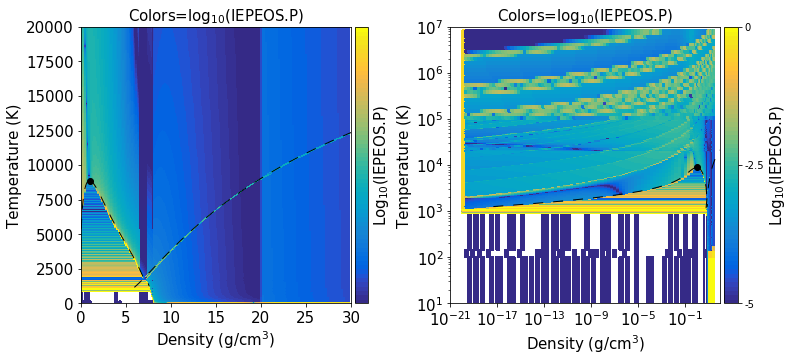

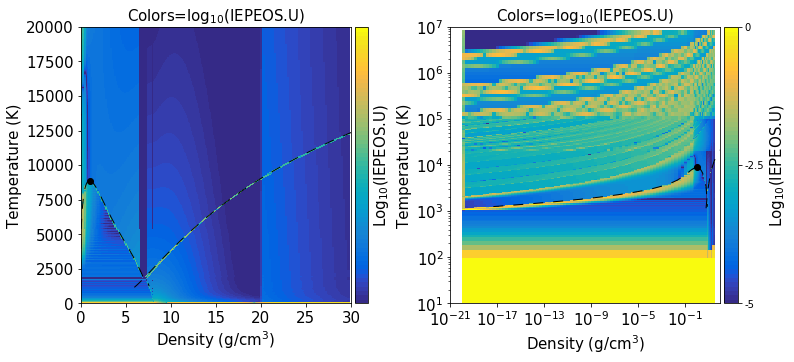

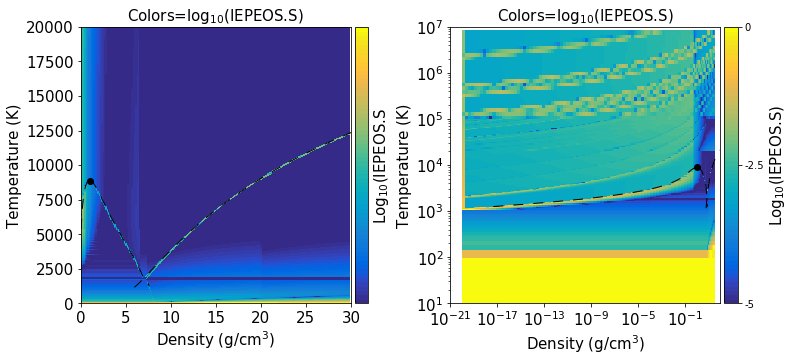

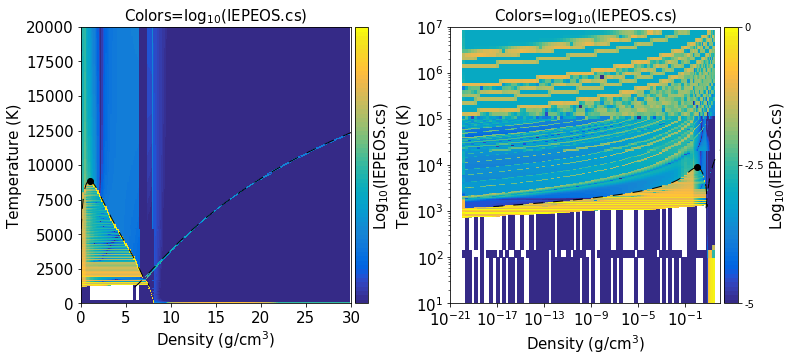

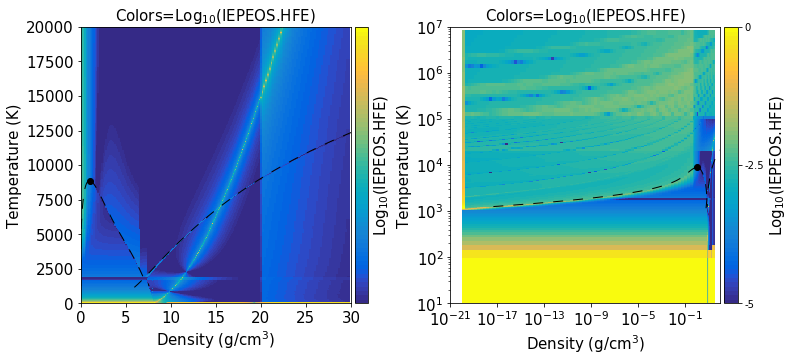

In [8]:
# PLOT COLOR SHADED VALUES RHO-T TABLE
lw=1
sfont = 15
ds = (10,10)

###%matplotlib inline
#fig, ([ax0, ax1], [ax2,ax3], [ax4,ax5])= plt.subplots(nrows=3,ncols=2,figsize=(14,24))
fig, ([ax0, ax1])= plt.subplots(nrows=1,ncols=2,figsize=(11,5))
plt.subplots_adjust(wspace=0.4)

##================ Pressure
im1=ax0.pcolormesh(EvenEOS.rho,EvenEOS.T,(np.log10(IEPEOS.P)+5)/5.,cmap=local_cmaps.parula,vmin=0,vmax=1,edgecolors='face')
ax0.plot(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax0.plot(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax0.plot(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax0.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax0.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax0.set_ylim(0.,20000)
ax0.set_xlim(0,30.)
ax0.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax0.set_ylabel('Temperature (K)',size=sfont)
ax0.set_title('Colors=log$_{10}$(IEPEOS.P)',size=sfont)
ax0.tick_params(labelsize=sfont)

divider0 = make_axes_locatable(ax0)
cax0 = divider0.append_axes('right', size='5%', pad=0.05)
cbar0 = fig.colorbar(im1, cax=cax0, ticks = [],orientation='vertical')
#cbar0.ax.set_yticklabels(['  ','  ','  '])  # vertical colorbar
cbar0.set_label('Log$_{10}$(IEPEOS.P)',size=sfont)
#cbar0.ax.set_yticklabels(['-25','-11','+4'])  # vertical colorbar

im1=ax1.pcolormesh(EvenEOS.rho,EvenEOS.T,(np.log10(IEPEOS.P)+5)/5.,cmap=local_cmaps.parula,vmin=0,vmax=1,edgecolors='face')
ax1.loglog(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax1.loglog(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax1.loglog(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax1.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax1.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax1.set_ylim(10.,1.E7)
ax1.set_xlim(1.E-21,100.)
ax1.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax1.set_ylabel('Temperature (K)',size=sfont)
ax1.set_title('Colors=log$_{10}$(IEPEOS.P)',size=sfont)
ax1.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
cbar.ax.set_yticklabels(['-5','-2.5', '0'])  # vertical colorbar
cbar.set_label('Log$_{10}$(IEPEOS.P)',size=sfont)

fig.show()
plt.tight_layout(pad=0.6)
plt.savefig('IEP-P.png', format='png', dpi=300,transparent=False)
fig, ([ax2, ax3])= plt.subplots(nrows=1,ncols=2,figsize=(11,5))
plt.subplots_adjust(wspace=0.4)

#================ Sp. Int. Energy
im1=ax2.pcolormesh(EvenEOS.rho,EvenEOS.T,(np.log10(IEPEOS.U)+5.)/5.,cmap=local_cmaps.parula,vmin=0,vmax=1,edgecolors='face')
ax2.plot(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax2.plot(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax2.plot(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax2.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax2.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax2.set_ylim(0.,20000)
ax2.set_xlim(0,30.)
ax2.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax2.set_ylabel('Temperature (K)',size=sfont)
ax2.set_title('Colors=log$_{10}$(IEPEOS.U)',size=sfont)
ax2.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
# does not want to label ticks in this location
cbar = fig.colorbar(im1, cax=cax, ticks = [], orientation='vertical')
#cbar.ax.set_yticklabels(['','',''])  # vertical colorbar
cbar.set_label('Log$_{10}$(IEPEOS.U)',size=sfont)
#cbar.ax.set_yticklabels(['-4','+1','+6'])  # vertical colorbar


ax3.pcolormesh(EvenEOS.rho,EvenEOS.T,(np.log10(IEPEOS.U)+5.)/5.,cmap=local_cmaps.parula,vmin=0,vmax=1)
ax3.loglog(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax3.loglog(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax3.loglog(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax3.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax3.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax3.set_ylim(10.,1.E7)
ax3.set_xlim(1.E-21,100.)
ax3.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax3.set_ylabel('Temperature (K)',size=sfont)
ax3.set_title('Colors=log$_{10}$(IEPEOS.U)',size=sfont)
ax3.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
#cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
#cbar.ax.set_yticklabels(['-6', '-3.5', '-1'])  # vertical colorbar
cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
cbar.ax.set_yticklabels(['-5', '-2.5','0'])  # vertical colorbar
cbar.set_label('Log$_{10}$(IEPEOS.U)',size=sfont)


fig.show()
plt.tight_layout(pad=0.6)
plt.savefig('IEP-U.png', format='png', dpi=300,transparent=False)

fig, ([ax4, ax5])= plt.subplots(nrows=1,ncols=2,figsize=(11,5))
plt.subplots_adjust(wspace=0.4)

#================ Sp. Entropy
im1=ax4.pcolormesh(EvenEOS.rho,EvenEOS.T,(np.log10(IEPEOS.S)+5.)/5.,cmap=local_cmaps.parula,vmin=0,vmax=1,edgecolors='face')
ax4.plot(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax4.plot(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax4.plot(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax4.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax4.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax4.set_ylim(0.,20000)
ax4.set_xlim(0,30.)
ax4.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax4.set_ylabel('Temperature (K)',size=sfont)
ax4.set_title('Colors=log$_{10}$(IEPEOS.S)',size=sfont)
ax4.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax, ticks = [], orientation='vertical')
#cbar.ax.set_yticklabels(['-4', '-2', '0'])  # vertical colorbar
cbar.set_label('Log$_{10}$(IEPEOS.S',size=sfont)


ax5.pcolormesh(EvenEOS.rho,EvenEOS.T,(np.log10(IEPEOS.S)+5.)/5.,cmap=local_cmaps.parula,vmin=0,vmax=1)
ax5.loglog(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax5.loglog(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax5.loglog(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax5.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax5.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax5.set_ylim(10.,1.E7)
ax5.set_xlim(1.E-21,100.)
ax5.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax5.set_ylabel('Temperature (K)',size=sfont)
ax5.set_title('Colors=log$_{10}$(IEPEOS.S)',size=sfont)
ax5.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax5)
cax = divider.append_axes('right', size='5%', pad=0.05)
#cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
#cbar.ax.set_yticklabels(['-6', '-3.5', '-1'])  # vertical colorbar
cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
cbar.ax.set_yticklabels(['-5', '-2.5','0'])  # vertical colorbar
cbar.set_label('Log$_{10}$(IEPEOS.S)',size=sfont)


fig.show()
plt.tight_layout(pad=0.6)
plt.savefig('IEP-S.png', format='png', dpi=300,transparent=False)

fig, ([ax0, ax1])= plt.subplots(nrows=1,ncols=2,figsize=(11,5))
plt.subplots_adjust(wspace=0.4)

#================ Sound Speed
im1=ax0.pcolormesh(EvenEOS.rho,EvenEOS.T,(np.log10(IEPEOS.cs)+5.)/5.,cmap=local_cmaps.parula,vmin=0,vmax=1,edgecolors='face')
ax0.plot(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax0.plot(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax0.plot(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax0.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax0.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax0.set_ylim(0.,20000)
ax0.set_xlim(0,30.)
ax0.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax0.set_ylabel('Temperature (K)',size=sfont)
ax0.set_title('Colors=log$_{10}$(IEPEOS.cs)',size=sfont)
ax0.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax, ticks = [], orientation='vertical')
#cbar.ax.set_yticklabels(['-3', '+2', '+7'])  # vertical colorbar
cbar.set_label('Log$_{10}$(IEPEOS.cs)',size=sfont)


ax1.pcolormesh(EvenEOS.rho,EvenEOS.T,(np.log10(IEPEOS.cs)+5.)/5.,cmap=local_cmaps.parula,vmin=0,vmax=1)
ax1.loglog(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax1.loglog(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax1.loglog(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax1.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax1.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax1.set_ylim(10.,1.E7)
ax1.set_xlim(1.E-21,100.)
ax1.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax1.set_ylabel('Temperature (K)',size=sfont)
ax1.set_title('Colors=log$_{10}$(IEPEOS.cs)',size=sfont)
ax1.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
#cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
#cbar.ax.set_yticklabels(['-6', '-3.5', '-1'])  # vertical colorbar
cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
cbar.ax.set_yticklabels(['-5', '-2.5', '0'])  # vertical colorbar
cbar.set_label('Log$_{10}$(IEPEOS.cs)',size=sfont)


fig.show()
plt.tight_layout(pad=0.6)
plt.savefig('IEP-cs.png', format='png', dpi=300,transparent=False)

fig, ([ax2, ax3])= plt.subplots(nrows=1,ncols=2,figsize=(11,5))
plt.subplots_adjust(wspace=0.4)

#================ HFE
im1=ax2.pcolormesh(EvenEOS.rho,EvenEOS.T,(np.log10(IEPEOS.A)+5.)/5.,cmap=local_cmaps.parula,vmin=0,vmax=1,edgecolors='face')
ax2.plot(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax2.plot(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax2.plot(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax2.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax2.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax2.set_ylim(0.,20000)
ax2.set_xlim(0,30.)
ax2.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax2.set_ylabel('Temperature (K)',size=sfont)
ax2.set_title('Colors=Log$_{10}$(IEPEOS.HFE)',size=sfont)
ax2.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax, ticks = [], orientation='vertical')
#cbar.ax.set_yticklabels(['-1000','-500','0','500'])  # vertical colorbar
cbar.set_label('Log$_{10}$(IEPEOS.HFE)',size=sfont)


ax3.pcolormesh(EvenEOS.rho,EvenEOS.T,(np.log10(IEPEOS.A)+5.)/5.,cmap=local_cmaps.parula,vmin=0,vmax=1)
ax3.loglog(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax3.loglog(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax3.loglog(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax3.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax3.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax3.set_ylim(10.,1.E7)
ax3.set_xlim(1.E-21,100.)
ax3.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax3.set_ylabel('Temperature (K)',size=sfont)
ax3.set_title('Colors=Log$_{10}$(IEPEOS.HFE)',size=sfont)
ax3.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
#cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
#cbar.ax.set_yticklabels(['-6', '-3.5', '-1'])  # vertical colorbar
cbar = fig.colorbar(im1, cax=cax, ticks = [0,0.5,  1], orientation='vertical')
cbar.ax.set_yticklabels(['-5','-2.5','0'])  # vertical colorbar
cbar.set_label('Log$_{10}$(IEPEOS.HFE)',size=sfont)

fig.show()
plt.tight_layout(pad=0.6)
plt.savefig('IEP-HFE.png', format='png', dpi=300,transparent=False)


In [9]:
%run RFI_2D.py

#===============================
# RATIONAL FUNCTION INTERPOLATION
#===============================
# FILL AN EOS STRUCTURE WITH IEP DATA FOR WRITING TO A FILE
IEPEOS = extEOStable() 

IEPEOS.MATID   = MATID
IEPEOS.DATE    = DATE
IEPEOS.VERSION = VERSION
IEPEOS.FMN     = FMN
IEPEOS.FMW     = FMW
IEPEOS.R0REF   = R0REF
IEPEOS.K0REF   = K0REF
IEPEOS.T0REF   = T0REF
IEPEOS.P0REF   = P0REF

IEPEOS.rho = np.copy(NewEOS.rho[::2])
IEPEOS.T = np.copy(NewEOS.T[::2])
IEPEOS.NT = len(IEPEOS.T)
IEPEOS.ND = len(IEPEOS.rho)

#==============================
# RATIONAL FUNCTION INTERPOLATION

oddrho = OddEOS.rho.reshape(OddEOS.rho.shape[0])
oddT = OddEOS.T.reshape(OddEOS.T.shape[0])
evenrho = EvenEOS.rho.reshape(EvenEOS.rho.shape[0])
evenT = EvenEOS.T.reshape(EvenEOS.T.shape[0])

IntEvenEOS = RFI_2D(oddrho,oddT,evenrho,evenT,OddEOS.P)
IEPEOS.P = abs((IntEvenEOS-EvenEOS.P)/EvenEOS.P)

IntEvenEOS = RFI_2D(OddEOS.rho,OddEOS.T,EvenEOS.rho,EvenEOS.T,OddEOS.U)
IEPEOS.U = abs((IntEvenEOS-EvenEOS.U)/EvenEOS.U)

IntEvenEOS = RFI_2D(OddEOS.rho,OddEOS.T,EvenEOS.rho,EvenEOS.T,OddEOS.S)
IEPEOS.S = abs((IntEvenEOS-EvenEOS.S)/EvenEOS.S)

IntEvenEOS = RFI_2D(OddEOS.rho,OddEOS.T,EvenEOS.rho,EvenEOS.T,OddEOS.A)
IEPEOS.A = abs((IntEvenEOS-EvenEOS.A)/EvenEOS.A)

IntEvenEOS = RFI_2D(OddEOS.rho,OddEOS.T,EvenEOS.rho,EvenEOS.T,OddEOS.cs)
IEPEOS.cs = abs((IntEvenEOS-EvenEOS.cs)/EvenEOS.cs)

if DEVMODE:
    #### WRITE MDQ Flag as a 301-style table
    IEPEOS.writeiepsesame(writestdsesfname="NEW-SESAME-IEP-RFI.TXT")

rfiIEPEOS = deepcopy(IEPEOS)
print('Done with RFI step')

Done writing the STD SESAME 301 notension table to local directory:  NEW-SESAME-IEP-RFI.TXT
Done with RFI step


<Figure size 432x288 with 0 Axes>

## Rational function interpolation


/Users/sstewart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/Users/sstewart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/Users/sstewart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/sstewart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:112: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/sstewart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:166: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/sstewart/anaconda3/lib/python3.7/site-packages/ipyke

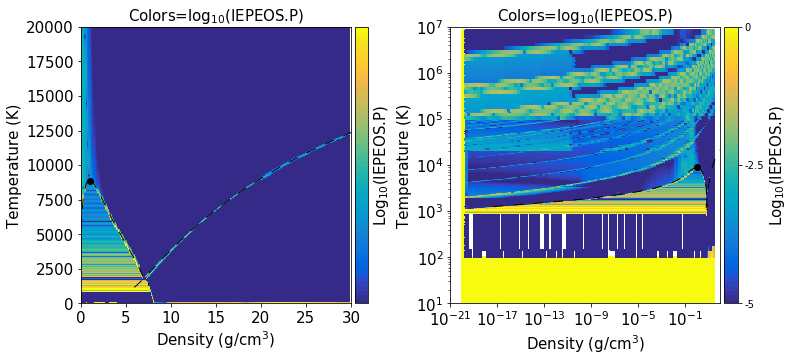

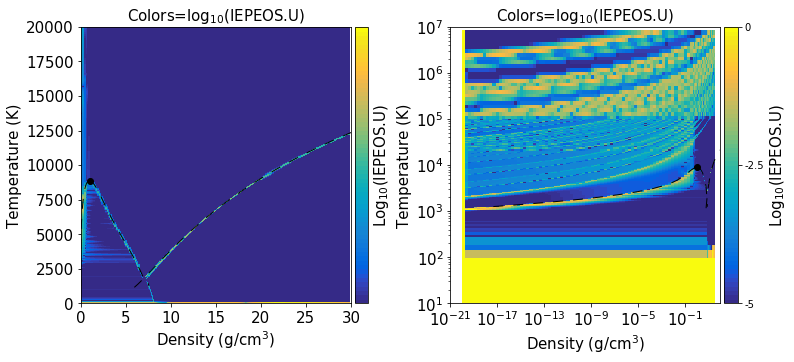

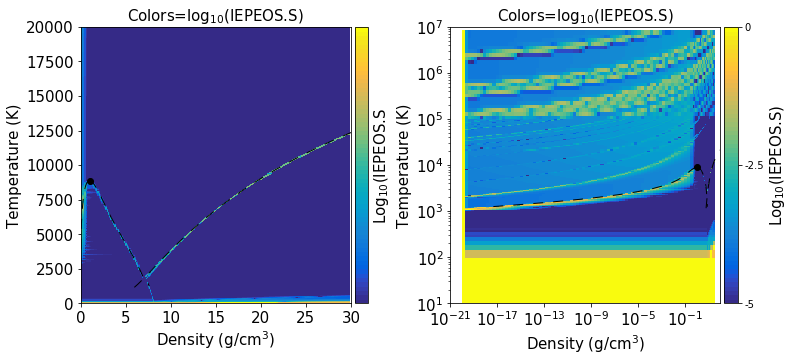

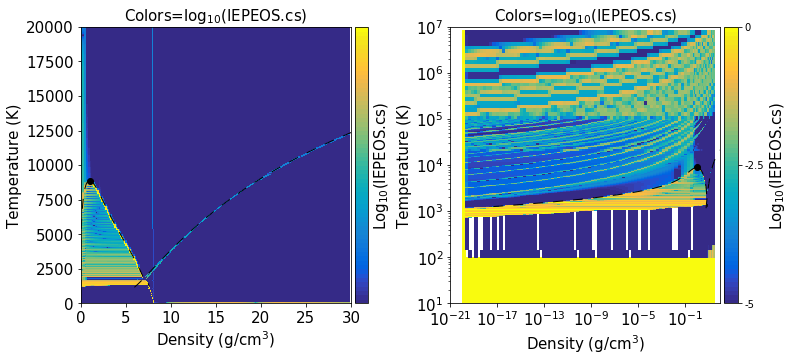

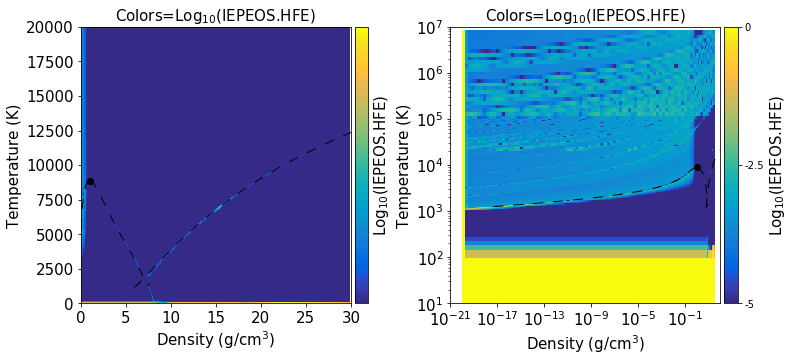

In [10]:
# PLOT COLOR SHADED VALUES RHO-T TABLE
lw=1
sfont = 15
ds = (10,10)
label='rfi-'

###%matplotlib inline
#fig, ([ax0, ax1], [ax2,ax3], [ax4,ax5])= plt.subplots(nrows=3,ncols=2,figsize=(14,24))
fig, ([ax0, ax1])= plt.subplots(nrows=1,ncols=2,figsize=(11,5))
plt.subplots_adjust(wspace=0.4)

##================ Pressure
im1=ax0.pcolormesh(EvenEOS.rho,EvenEOS.T,(np.log10(IEPEOS.P)+5)/5.,cmap=local_cmaps.parula,vmin=0,vmax=1,edgecolors='face')
ax0.plot(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax0.plot(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax0.plot(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax0.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax0.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax0.set_ylim(0.,20000)
ax0.set_xlim(0,30.)
ax0.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax0.set_ylabel('Temperature (K)',size=sfont)
ax0.set_title('Colors=log$_{10}$(IEPEOS.P)',size=sfont)
ax0.tick_params(labelsize=sfont)

divider0 = make_axes_locatable(ax0)
cax0 = divider0.append_axes('right', size='5%', pad=0.05)
cbar0 = fig.colorbar(im1, cax=cax0, ticks = [],orientation='vertical')
#cbar0.ax.set_yticklabels(['  ','  ','  '])  # vertical colorbar
cbar0.set_label('Log$_{10}$(IEPEOS.P)',size=sfont)
#cbar0.ax.set_yticklabels(['-25','-11','+4'])  # vertical colorbar

im1=ax1.pcolormesh(EvenEOS.rho,EvenEOS.T,(np.log10(IEPEOS.P)+5)/5.,cmap=local_cmaps.parula,vmin=0,vmax=1,edgecolors='face')
ax1.loglog(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax1.loglog(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax1.loglog(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax1.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax1.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax1.set_ylim(10.,1.E7)
ax1.set_xlim(1.E-21,100.)
ax1.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax1.set_ylabel('Temperature (K)',size=sfont)
ax1.set_title('Colors=log$_{10}$(IEPEOS.P)',size=sfont)
ax1.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
cbar.ax.set_yticklabels(['-5','-2.5', '0'])  # vertical colorbar
cbar.set_label('Log$_{10}$(IEPEOS.P)',size=sfont)

fig.show()
plt.tight_layout(pad=0.6)
plt.savefig(label+'IEP-P.png', format='png', dpi=300,transparent=False)
fig, ([ax2, ax3])= plt.subplots(nrows=1,ncols=2,figsize=(11,5))
plt.subplots_adjust(wspace=0.4)


#================ Sp. Int. Energy
im1=ax2.pcolormesh(EvenEOS.rho,EvenEOS.T,(np.log10(IEPEOS.U)+5.)/5.,cmap=local_cmaps.parula,vmin=0,vmax=1,edgecolors='face')
ax2.plot(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax2.plot(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax2.plot(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax2.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax2.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax2.set_ylim(0.,20000)
ax2.set_xlim(0,30.)
ax2.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax2.set_ylabel('Temperature (K)',size=sfont)
ax2.set_title('Colors=log$_{10}$(IEPEOS.U)',size=sfont)
ax2.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
# does not want to label ticks in this location
cbar = fig.colorbar(im1, cax=cax, ticks = [], orientation='vertical')
#cbar.ax.set_yticklabels(['','',''])  # vertical colorbar
cbar.set_label('Log$_{10}$(IEPEOS.U)',size=sfont)
#cbar.ax.set_yticklabels(['-4','+1','+6'])  # vertical colorbar


ax3.pcolormesh(EvenEOS.rho,EvenEOS.T,(np.log10(IEPEOS.U)+5.)/5.,cmap=local_cmaps.parula,vmin=0,vmax=1)
ax3.loglog(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax3.loglog(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax3.loglog(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax3.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax3.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax3.set_ylim(10.,1.E7)
ax3.set_xlim(1.E-21,100.)
ax3.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax3.set_ylabel('Temperature (K)',size=sfont)
ax3.set_title('Colors=log$_{10}$(IEPEOS.U)',size=sfont)
ax3.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
#cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
#cbar.ax.set_yticklabels(['-6', '-3.5', '-1'])  # vertical colorbar
cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
cbar.ax.set_yticklabels(['-5', '-2.5','0'])  # vertical colorbar
cbar.set_label('Log$_{10}$(IEPEOS.U)',size=sfont)


fig.show()
plt.tight_layout(pad=0.6)
plt.savefig(label+'IEP-U.png', format='png', dpi=300,transparent=False)

fig, ([ax4, ax5])= plt.subplots(nrows=1,ncols=2,figsize=(11,5))
plt.subplots_adjust(wspace=0.4)

#================ Sp. Entropy
im1=ax4.pcolormesh(EvenEOS.rho,EvenEOS.T,(np.log10(IEPEOS.S)+5.)/5.,cmap=local_cmaps.parula,vmin=0,vmax=1,edgecolors='face')
ax4.plot(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax4.plot(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax4.plot(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax4.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax4.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax4.set_ylim(0.,20000)
ax4.set_xlim(0,30.)
ax4.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax4.set_ylabel('Temperature (K)',size=sfont)
ax4.set_title('Colors=log$_{10}$(IEPEOS.S)',size=sfont)
ax4.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax, ticks = [], orientation='vertical')
#cbar.ax.set_yticklabels(['-4', '-2', '0'])  # vertical colorbar
cbar.set_label('Log$_{10}$(IEPEOS.S',size=sfont)


ax5.pcolormesh(EvenEOS.rho,EvenEOS.T,(np.log10(IEPEOS.S)+5.)/5.,cmap=local_cmaps.parula,vmin=0,vmax=1)
ax5.loglog(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax5.loglog(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax5.loglog(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax5.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax5.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax5.set_ylim(10.,1.E7)
ax5.set_xlim(1.E-21,100.)
ax5.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax5.set_ylabel('Temperature (K)',size=sfont)
ax5.set_title('Colors=log$_{10}$(IEPEOS.S)',size=sfont)
ax5.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax5)
cax = divider.append_axes('right', size='5%', pad=0.05)
#cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
#cbar.ax.set_yticklabels(['-6', '-3.5', '-1'])  # vertical colorbar
cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
cbar.ax.set_yticklabels(['-5', '-2.5','0'])  # vertical colorbar
cbar.set_label('Log$_{10}$(IEPEOS.S)',size=sfont)


fig.show()
plt.tight_layout(pad=0.6)
plt.savefig(label+'IEP-S.png', format='png', dpi=300,transparent=False)

fig, ([ax0, ax1])= plt.subplots(nrows=1,ncols=2,figsize=(11,5))
plt.subplots_adjust(wspace=0.4)

#================ Sound Speed
im1=ax0.pcolormesh(EvenEOS.rho,EvenEOS.T,(np.log10(IEPEOS.cs)+5.)/5.,cmap=local_cmaps.parula,vmin=0,vmax=1,edgecolors='face')
ax0.plot(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax0.plot(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax0.plot(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax0.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax0.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax0.set_ylim(0.,20000)
ax0.set_xlim(0,30.)
ax0.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax0.set_ylabel('Temperature (K)',size=sfont)
ax0.set_title('Colors=log$_{10}$(IEPEOS.cs)',size=sfont)
ax0.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax, ticks = [], orientation='vertical')
#cbar.ax.set_yticklabels(['-3', '+2', '+7'])  # vertical colorbar
cbar.set_label('Log$_{10}$(IEPEOS.cs)',size=sfont)


ax1.pcolormesh(EvenEOS.rho,EvenEOS.T,(np.log10(IEPEOS.cs)+5.)/5.,cmap=local_cmaps.parula,vmin=0,vmax=1)
ax1.loglog(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax1.loglog(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax1.loglog(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax1.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax1.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax1.set_ylim(10.,1.E7)
ax1.set_xlim(1.E-21,100.)
ax1.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax1.set_ylabel('Temperature (K)',size=sfont)
ax1.set_title('Colors=log$_{10}$(IEPEOS.cs)',size=sfont)
ax1.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
#cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
#cbar.ax.set_yticklabels(['-6', '-3.5', '-1'])  # vertical colorbar
cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
cbar.ax.set_yticklabels(['-5', '-2.5', '0'])  # vertical colorbar
cbar.set_label('Log$_{10}$(IEPEOS.cs)',size=sfont)


fig.show()
plt.tight_layout(pad=0.6)
plt.savefig(label+'IEP-cs.png', format='png', dpi=300,transparent=False)

fig, ([ax2, ax3])= plt.subplots(nrows=1,ncols=2,figsize=(11,5))
plt.subplots_adjust(wspace=0.4)

#================ HFE
im1=ax2.pcolormesh(EvenEOS.rho,EvenEOS.T,(np.log10(IEPEOS.A)+5.)/5.,cmap=local_cmaps.parula,vmin=0,vmax=1,edgecolors='face')
ax2.plot(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax2.plot(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax2.plot(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax2.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax2.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax2.set_ylim(0.,20000)
ax2.set_xlim(0,30.)
ax2.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax2.set_ylabel('Temperature (K)',size=sfont)
ax2.set_title('Colors=Log$_{10}$(IEPEOS.HFE)',size=sfont)
ax2.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax, ticks = [], orientation='vertical')
#cbar.ax.set_yticklabels(['-1000','-500','0','500'])  # vertical colorbar
cbar.set_label('Log$_{10}$(IEPEOS.HFE)',size=sfont)


ax3.pcolormesh(EvenEOS.rho,EvenEOS.T,(np.log10(IEPEOS.A)+5.)/5.,cmap=local_cmaps.parula,vmin=0,vmax=1)
ax3.loglog(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax3.loglog(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax3.loglog(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax3.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax3.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax3.set_ylim(10.,1.E7)
ax3.set_xlim(1.E-21,100.)
ax3.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax3.set_ylabel('Temperature (K)',size=sfont)
ax3.set_title('Colors=Log$_{10}$(IEPEOS.HFE)',size=sfont)
ax3.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
#cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
#cbar.ax.set_yticklabels(['-6', '-3.5', '-1'])  # vertical colorbar
cbar = fig.colorbar(im1, cax=cax, ticks = [0,0.5,  1], orientation='vertical')
cbar.ax.set_yticklabels(['-5','-2.5','0'])  # vertical colorbar
cbar.set_label('Log$_{10}$(IEPEOS.HFE)',size=sfont)

fig.show()
plt.tight_layout(pad=0.6)
plt.savefig(label+'IEP-HFE.png', format='png', dpi=300,transparent=False)


## Compare bilinear interpolation and rational function interpolation

/Users/sstewart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/sstewart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/Users/sstewart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/sstewart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/sstewart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/sstewart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:124: UserWarning: Matplotlib is cur

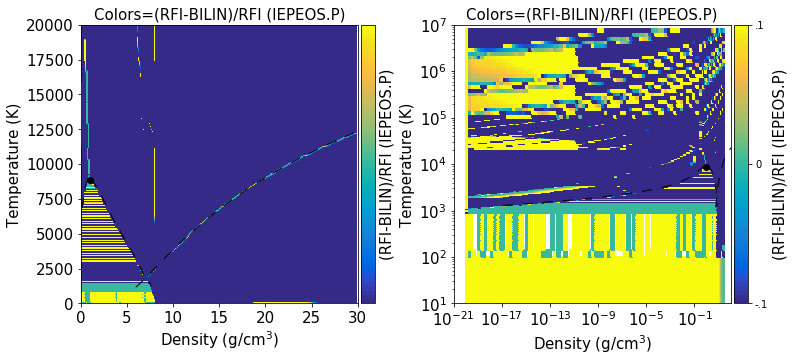

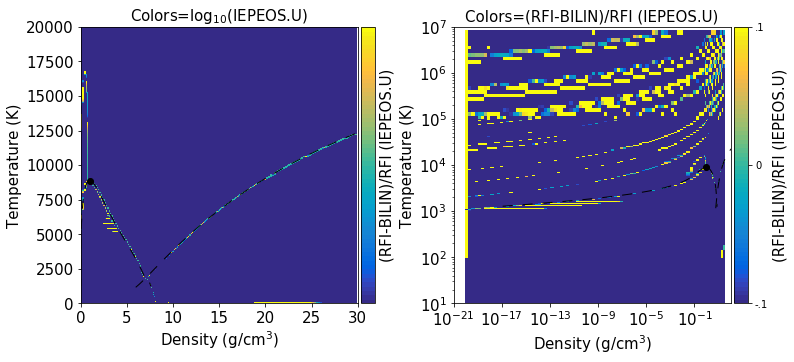

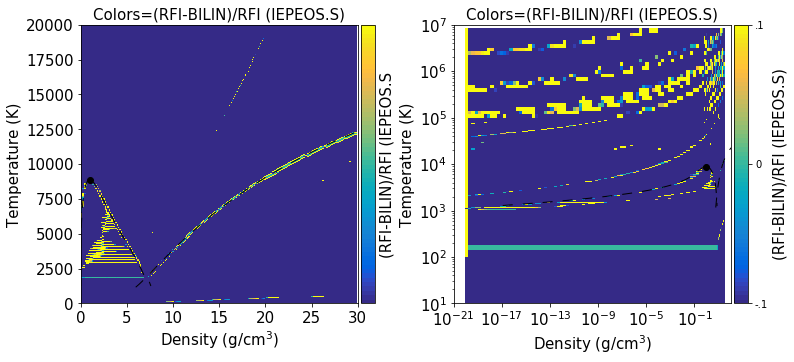

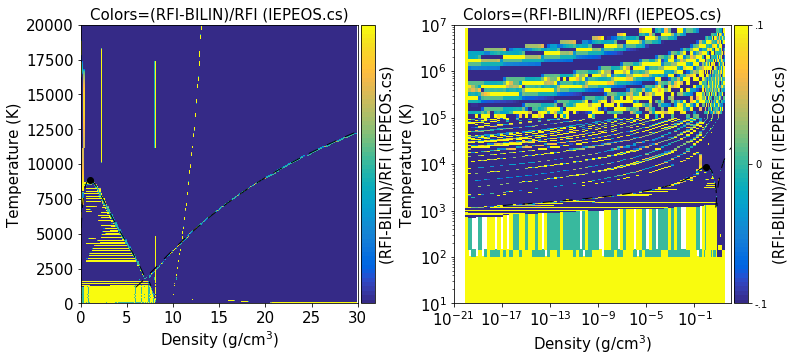

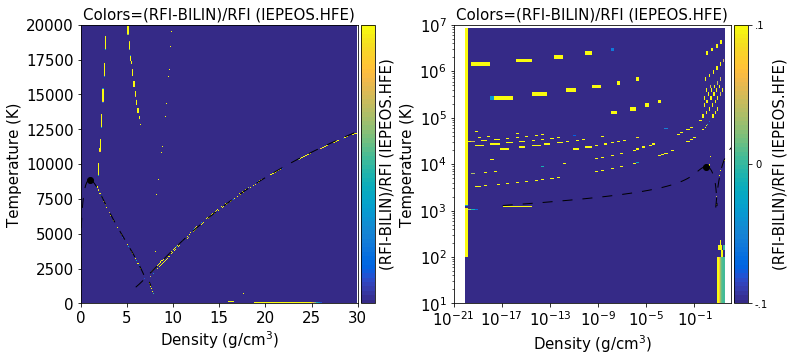

In [15]:
if 1:
    # read in the IEP values from the file (previously computed above)
    bilinearIEPEOS = extEOStable() 
    bilinearIEPEOS.loadiepsesame('NEW-SESAME-IEP-BILINEAR.TXT')
    rfiIEPEOS = extEOStable() 
    rfiIEPEOS.loadiepsesame('NEW-SESAME-IEP-RFI.TXT')
    IEPEOS = extEOStable()
    IEPEOS.P = (rfiIEPEOS.P-bilinearIEPEOS.P)/rfiIEPEOS.P
    IEPEOS.U = (rfiIEPEOS.U-bilinearIEPEOS.U)/rfiIEPEOS.U
    IEPEOS.A = (rfiIEPEOS.A-bilinearIEPEOS.A)/rfiIEPEOS.A
    IEPEOS.cs = (rfiIEPEOS.cs-bilinearIEPEOS.cs)/rfiIEPEOS.cs
    IEPEOS.S = (rfiIEPEOS.S-bilinearIEPEOS.S)/rfiIEPEOS.S
    
# PLOT COLOR SHADED VALUES RHO-T TABLE
lw=1
sfont = 15
ds = (10,10)
label='rfi-bilin-'

###%matplotlib inline
#fig, ([ax0, ax1], [ax2,ax3], [ax4,ax5])= plt.subplots(nrows=3,ncols=2,figsize=(14,24))
fig, ([ax0, ax1])= plt.subplots(nrows=1,ncols=2,figsize=(11,5))
plt.subplots_adjust(wspace=0.4)

##================ Pressure
im1=ax0.pcolormesh(EvenEOS.rho,EvenEOS.T,IEPEOS.P,cmap=local_cmaps.parula,vmin=-.1,vmax=.1,edgecolors='face')
ax0.plot(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax0.plot(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax0.plot(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax0.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax0.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax0.set_ylim(0.,20000)
ax0.set_xlim(0,30.)
ax0.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax0.set_ylabel('Temperature (K)',size=sfont)
ax0.set_title('Colors=(RFI-BILIN)/RFI (IEPEOS.P)',size=sfont)
ax0.tick_params(labelsize=sfont)

divider0 = make_axes_locatable(ax0)
cax0 = divider0.append_axes('right', size='5%', pad=0.05)
cbar0 = fig.colorbar(im1, cax=cax0, ticks = [],orientation='vertical')
#cbar0.ax.set_yticklabels(['  ','  ','  '])  # vertical colorbar
cbar0.set_label('(RFI-BILIN)/RFI (IEPEOS.P)',size=sfont)
#cbar0.ax.set_yticklabels(['-25','-11','+4'])  # vertical colorbar

im1=ax1.pcolormesh(EvenEOS.rho,EvenEOS.T,IEPEOS.P,cmap=local_cmaps.parula,vmin=-.1,vmax=.1,edgecolors='face')
ax1.loglog(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax1.loglog(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax1.loglog(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax1.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax1.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax1.set_ylim(10.,1.E7)
ax1.set_xlim(1.E-21,100.)
ax1.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax1.set_ylabel('Temperature (K)',size=sfont)
ax1.set_title('Colors=(RFI-BILIN)/RFI (IEPEOS.P)',size=sfont)
ax1.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax, ticks = [-.1,0,.1], orientation='vertical')
cbar.ax.set_yticklabels(['-.1','0', '.1'])  # vertical colorbar
cbar.set_label('(RFI-BILIN)/RFI (IEPEOS.P)',size=sfont)

fig.show()
plt.tight_layout(pad=0.6)
plt.savefig(label+'IEP-P.png', format='png', dpi=300,transparent=False)
fig, ([ax2, ax3])= plt.subplots(nrows=1,ncols=2,figsize=(11,5))
plt.subplots_adjust(wspace=0.4)

#================ Sp. Int. Energy
im1=ax2.pcolormesh(EvenEOS.rho,EvenEOS.T,IEPEOS.U,cmap=local_cmaps.parula,vmin=-.1,vmax=.1,edgecolors='face')
ax2.plot(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax2.plot(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax2.plot(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax2.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax2.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax2.set_ylim(0.,20000)
ax2.set_xlim(0,30.)
ax2.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax2.set_ylabel('Temperature (K)',size=sfont)
ax2.set_title('Colors=log$_{10}$(IEPEOS.U)',size=sfont)
ax2.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
# does not want to label ticks in this location
cbar = fig.colorbar(im1, cax=cax, ticks = [], orientation='vertical')
#cbar.ax.set_yticklabels(['','',''])  # vertical colorbar
cbar.set_label('(RFI-BILIN)/RFI (IEPEOS.U)',size=sfont)
#cbar.ax.set_yticklabels(['-4','+1','+6'])  # vertical colorbar


ax3.pcolormesh(EvenEOS.rho,EvenEOS.T,IEPEOS.U,cmap=local_cmaps.parula,vmin=-.1,vmax=.1)
ax3.loglog(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax3.loglog(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax3.loglog(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax3.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax3.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax3.set_ylim(10.,1.E7)
ax3.set_xlim(1.E-21,100.)
ax3.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax3.set_ylabel('Temperature (K)',size=sfont)
ax3.set_title('Colors=(RFI-BILIN)/RFI (IEPEOS.U)',size=sfont)
ax3.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
#cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
#cbar.ax.set_yticklabels(['-6', '-3.5', '-1'])  # vertical colorbar
cbar = fig.colorbar(im1, cax=cax, ticks = [-.1,0,.1], orientation='vertical')
cbar.ax.set_yticklabels(['-.1', '0','.1'])  # vertical colorbar
cbar.set_label('(RFI-BILIN)/RFI (IEPEOS.U)',size=sfont)


fig.show()
plt.tight_layout(pad=0.6)
plt.savefig(label+'IEP-U.png', format='png', dpi=300,transparent=False)

fig, ([ax4, ax5])= plt.subplots(nrows=1,ncols=2,figsize=(11,5))
plt.subplots_adjust(wspace=0.4)

#================ Sp. Entropy
im1=ax4.pcolormesh(EvenEOS.rho,EvenEOS.T,IEPEOS.S,cmap=local_cmaps.parula,vmin=-.1,vmax=.1,edgecolors='face')
ax4.plot(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax4.plot(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax4.plot(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax4.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax4.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax4.set_ylim(0.,20000)
ax4.set_xlim(0,30.)
ax4.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax4.set_ylabel('Temperature (K)',size=sfont)
ax4.set_title('Colors=(RFI-BILIN)/RFI (IEPEOS.S)',size=sfont)
ax4.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax, ticks = [], orientation='vertical')
#cbar.ax.set_yticklabels(['-4', '-2', '0'])  # vertical colorbar
cbar.set_label('(RFI-BILIN)/RFI (IEPEOS.S',size=sfont)


ax5.pcolormesh(EvenEOS.rho,EvenEOS.T,IEPEOS.S,cmap=local_cmaps.parula,vmin=-.1,vmax=.1)
ax5.loglog(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax5.loglog(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax5.loglog(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax5.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax5.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax5.set_ylim(10.,1.E7)
ax5.set_xlim(1.E-21,100.)
ax5.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax5.set_ylabel('Temperature (K)',size=sfont)
ax5.set_title('Colors=(RFI-BILIN)/RFI (IEPEOS.S)',size=sfont)
ax5.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax5)
cax = divider.append_axes('right', size='5%', pad=0.05)
#cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
#cbar.ax.set_yticklabels(['-6', '-3.5', '-1'])  # vertical colorbar
cbar = fig.colorbar(im1, cax=cax, ticks = [-.1,0,.1], orientation='vertical')
cbar.ax.set_yticklabels(['-.1', '0','.1'])  # vertical colorbar
cbar.set_label('(RFI-BILIN)/RFI (IEPEOS.S)',size=sfont)


fig.show()
plt.tight_layout(pad=0.6)
plt.savefig(label+'IEP-S.png', format='png', dpi=300,transparent=False)

fig, ([ax0, ax1])= plt.subplots(nrows=1,ncols=2,figsize=(11,5))
plt.subplots_adjust(wspace=0.4)

#================ Sound Speed
im1=ax0.pcolormesh(EvenEOS.rho,EvenEOS.T,IEPEOS.cs,cmap=local_cmaps.parula,vmin=-.1,vmax=.1,edgecolors='face')
ax0.plot(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax0.plot(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax0.plot(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax0.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax0.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax0.set_ylim(0.,20000)
ax0.set_xlim(0,30.)
ax0.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax0.set_ylabel('Temperature (K)',size=sfont)
ax0.set_title('Colors=(RFI-BILIN)/RFI (IEPEOS.cs)',size=sfont)
ax0.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax, ticks = [], orientation='vertical')
#cbar.ax.set_yticklabels(['-3', '+2', '+7'])  # vertical colorbar
cbar.set_label('(RFI-BILIN)/RFI (IEPEOS.cs)',size=sfont)


ax1.pcolormesh(EvenEOS.rho,EvenEOS.T,IEPEOS.cs,cmap=local_cmaps.parula,vmin=-.1,vmax=.1)
ax1.loglog(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax1.loglog(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax1.loglog(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax1.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax1.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax1.set_ylim(10.,1.E7)
ax1.set_xlim(1.E-21,100.)
ax1.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax1.set_ylabel('Temperature (K)',size=sfont)
ax1.set_title('Colors=(RFI-BILIN)/RFI (IEPEOS.cs)',size=sfont)
ax1.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
#cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
#cbar.ax.set_yticklabels(['-6', '-3.5', '-1'])  # vertical colorbar
cbar = fig.colorbar(im1, cax=cax, ticks = [-.1,0,.1], orientation='vertical')
cbar.ax.set_yticklabels(['-.1', '0', '.1'])  # vertical colorbar
cbar.set_label('(RFI-BILIN)/RFI (IEPEOS.cs)',size=sfont)


fig.show()
plt.tight_layout(pad=0.6)
plt.savefig(label+'IEP-cs.png', format='png', dpi=300,transparent=False)

fig, ([ax2, ax3])= plt.subplots(nrows=1,ncols=2,figsize=(11,5))
plt.subplots_adjust(wspace=0.4)

#================ HFE
im1=ax2.pcolormesh(EvenEOS.rho,EvenEOS.T,IEPEOS.A,cmap=local_cmaps.parula,vmin=-.1,vmax=.1,edgecolors='face')
ax2.plot(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax2.plot(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax2.plot(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax2.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax2.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax2.set_ylim(0.,20000)
ax2.set_xlim(0,30.)
ax2.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax2.set_ylabel('Temperature (K)',size=sfont)
ax2.set_title('Colors=(RFI-BILIN)/RFI (IEPEOS.HFE)',size=sfont)
ax2.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax, ticks = [], orientation='vertical')
#cbar.ax.set_yticklabels(['-1000','-500','0','500'])  # vertical colorbar
cbar.set_label('(RFI-BILIN)/RFI (IEPEOS.HFE)',size=sfont)


ax3.pcolormesh(EvenEOS.rho,EvenEOS.T,IEPEOS.A,cmap=local_cmaps.parula,vmin=-.1,vmax=.1)
ax3.loglog(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax3.loglog(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax3.loglog(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax3.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax3.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax3.set_ylim(10.,1.E7)
ax3.set_xlim(1.E-21,100.)
ax3.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax3.set_ylabel('Temperature (K)',size=sfont)
ax3.set_title('Colors=(RFI-BILIN)/RFI (IEPEOS.HFE)',size=sfont)
ax3.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
#cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
#cbar.ax.set_yticklabels(['-6', '-3.5', '-1'])  # vertical colorbar
cbar = fig.colorbar(im1, cax=cax, ticks = [-.1,0,.1], orientation='vertical')
cbar.ax.set_yticklabels(['-.1','0','.1'])  # vertical colorbar
cbar.set_label('(RFI-BILIN)/RFI (IEPEOS.HFE)',size=sfont)

fig.show()
plt.tight_layout(pad=0.6)
plt.savefig(label+'IEP-HFE.png', format='png', dpi=300,transparent=False)


END OF NOTEBOOK